In [1]:
#Author:Bhishma Dedhia

import torch
import torch.nn as nn
import os
import sys
import numpy as np
import argparse
import yaml
import pandas as pd
from matplotlib import pyplot as plt
sys.path.append('../dsc/')
sys.path.append("../..")
sys.path.append("../../tslib/src/")
sys.path.append("../../tslib/")
sys.path.append(os.getcwd())
from dsc_model import DSCModel
from bert2bert import Bert2BertSynCtrl
from transformers import BertConfig
from src import tsUtils
from src.synthcontrol.syntheticControl import RobustSyntheticControl
from src.synthcontrol.multisyntheticControl import MultiRobustSyntheticControl
%load_ext autoreload
%autoreload 2

In [3]:
#Training noise experiments only on finetuning
noise_array = [0.5]
for noise in noise_array:
    datapath = f'../datasets/synthetic_data_noise_{noise}/'
    config_path = '../exp_configs/synthetic_noise/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_noise_{noise}/'
    if not(os.path.exists(op_path)):
        os.mkdir(op_path)
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = False
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = False,
                        classes=None)
    dscmodel.fit(interv_time,pretrain=False)

TypeError: __init__() missing 2 required positional arguments: 'topk' and 'weights'

In [3]:
#Extracting results for Noise experiments
noise_array = [0.5,1,2]
rsc_array = []
mrsc_array = []
dsc_array = []
sync_twin = []
mc_nnm = []
dsc_no_pretrain = []
mean_array = []
obs_matrix = []
mean_array_full = []
id = [1,2,3,4]
for noise in noise_array:
    for i in id:
        print(noise, i)
        datapath = f'../datasets/synthetic_noise{noise}_{i}/'
        config_path = '../exp_configs/synthetic_noise/config.yaml'
        config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
        op_path = f'../logs_dir/synthetic_noise_{noise}_{i}/'
        if not(os.path.exists(op_path)):
            os.mkdir(op_path)
        random_seed = 0
        target_index = 0
        interv_time = 1500
        lowrank = False
        device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
        classes = None
        config_model = BertConfig(hidden_size = config['hidden_size'],
                                num_hidden_layers = config['n_layers'],
                                num_attention_heads = config['n_heads'],
                                intermediate_size = 4*config['hidden_size'],
                                vocab_size = 0,
                                max_position_embeddings = 0,
                                output_hidden_states = True,
                                )

        config_model.add_syn_ctrl_config(K=config['K'],
                                        pre_int_len=config['pre_int_len'],
                                        post_int_len=config['post_int_len'],
                                        feature_dim=config['feature_dim'],
                                        time_range=config['time_range'],
                                        seq_range=config['seq_range'],
                                        cont_dim=config['cont_dim'],
                                        discrete_dim=config['discrete_dim'],
                                        classes = classes)
        model = Bert2BertSynCtrl(config_model, random_seed)
        model = model.to(device)
        dscmodel = DSCModel(model,
                            config,
                            op_path,
                            target_index,
                            random_seed,
                            datapath,
                            device,
                            lowrank = False,
                            classes=None)

        model_path = f'../logs_dir/synthetic_noise_{noise}/finetune/model.pth'
        dscmodel.load_model_from_checkpoint(model_path)
        op = dscmodel.predict(interv_time)
        if noise == 1:
            np.save(op_path+'target.npy',op)
        obs = np.load(datapath+'obs1.npy')
        obs_matrix.append(obs[0])

        model_path = f'../logs_dir/synthetic_noise_{noise}/finetune_only/model.pth'
        dscmodel.load_model_from_checkpoint(model_path)
        op_2 = dscmodel.predict(interv_time)

        #MSE
        meanmatrix = np.load(datapath+'mean1.npy')
        test_mean = meanmatrix[0,interv_time:]
        pred_mean=op[interv_time:]
        pred_mean2 = op_2[interv_time:]
        print('With pretraining:',np.sqrt(np.mean((pred_mean - test_mean)**2)))
        print('Without pretraining:',np.sqrt(np.mean((pred_mean2 - test_mean)**2)))
        mean_array_full.append(meanmatrix[0])
        mean_array.append(test_mean)
        dsc_array.append(pred_mean)
        dsc_no_pretrain.append(pred_mean2)
        rsc_array.append(np.load(datapath+'rsc_pred.npy'))
        mrsc_array.append(np.load(datapath+'mrsc_pred.npy'))
        mc_nnm.append(pd.read_csv(datapath+'mc_nnm_pred.csv', sep=',',header=None))
        sync_twin.append(np.load(datapath+'pred_synctwin.npy'))

0.5 1
Modifying K
With pretraining: 0.4140702391038812
Without pretraining: 1.3117882124466584
0.5 2
Modifying K
With pretraining: 0.41626677962049496
Without pretraining: 1.330616147857379
0.5 3
Modifying K
With pretraining: 0.3783117796511842
Without pretraining: 1.3109220538234014
0.5 4
Modifying K
With pretraining: 0.2924703473988418
Without pretraining: 1.25546711588041
1 1
Modifying K
With pretraining: 0.5909652555901721
Without pretraining: 1.5340526776044099
1 2
Modifying K
With pretraining: 0.5613722133588968
Without pretraining: 1.4744584974502397
1 3
Modifying K
With pretraining: 0.6017875994672012
Without pretraining: 1.3933305428099683
1 4
Modifying K
With pretraining: 0.5951586897215412
Without pretraining: 1.540559451257493
2 1
Modifying K
With pretraining: 1.148147501832612
Without pretraining: 1.8259631209574054
2 2
Modifying K
With pretraining: 1.5889384694959476
Without pretraining: 2.1376289529173356
2 3
Modifying K
With pretraining: 1.02664294966848
Without pretrai

In [17]:
mc_nnm[0].values[1:,].reshape(-1)

array(['2.46511589185215', '2.89685907395576', '2.63306920372888',
       '2.64892702966895', '2.22131914896395', '2.88741029798962',
       '2.29256088605073', '1.98444311737078', '2.37933832329748',
       '2.67476616589873', '2.79073265324479', '2.71825889876078',
       '2.25354530264046', '2.30174156644626', '2.17071418040953',
       '1.76970558276506', '2.28674496869349', '2.94874487343429',
       '2.3479004648971', '2.3065216151705', '1.92191595865217',
       '2.02270460575496', '1.83326007232147', '2.25178131034374',
       '2.02951461493079', '1.96207162413787', '2.48809859802768',
       '2.07139222345104', '1.97839434972725', '2.24619851876746',
       '2.17255491643927', '2.06619663422854', '1.95189630919247',
       '2.24774215593221', '2.61663019041854', '2.1855065636552',
       '2.1045503625813', '1.86375300175906', '2.29079848045244',
       '2.2211460536843', '1.90729804801006', '2.48751419165182',
       '2.33229859039378', '2.31399586302456', '2.26370332550442',


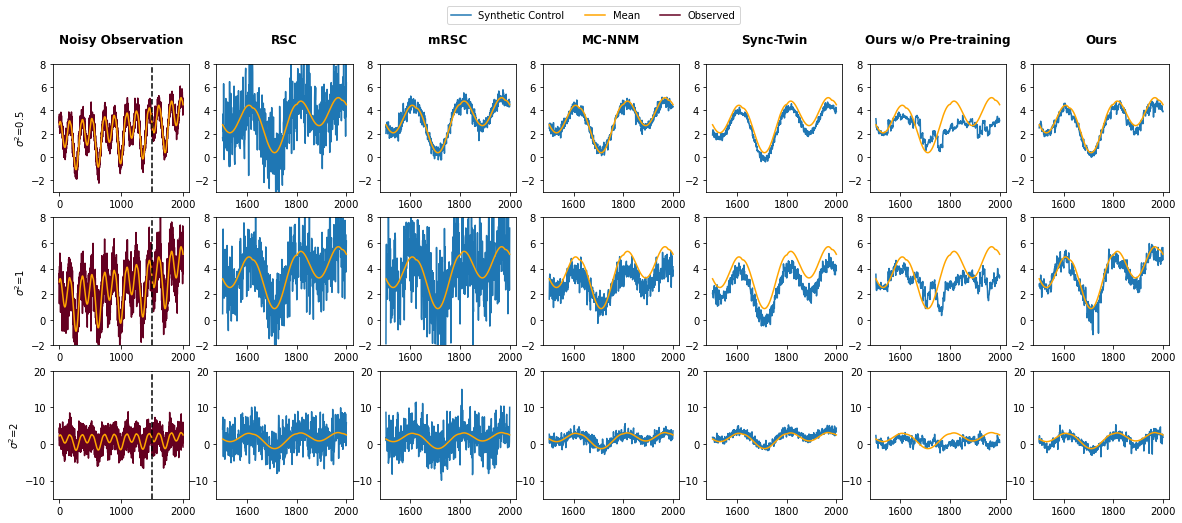

In [5]:
#Plot noise
fig, big_axes = plt.subplots(figsize=(20, 8) , nrows=1, ncols=7, sharey=True) 
x = np.arange(interv_time,2000)+1
x_full =  np.arange(2000)+1
for title, big_ax in zip(['Noisy Observation','RSC', 'mRSC','MC-NNM','Sync-Twin','Ours w/o Pre-training','Ours'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')

noise_array = [0.5,1,2]
custom_ylim = [[-3,8],[-2,8],[-15,20]]

for i in range(1,22,7):
    a1 = fig.add_subplot(3,7,i)
    plt.setp(a1,ylim=custom_ylim[int(i/7)])
    l1=a1.plot(x_full,obs_matrix[int(i/7)],'xkcd:maroon',label='Observed')
    l2=a1.plot(x_full,mean_array_full[int(i/7)],'orange',label='Mean')
    plt.axvline(x =1500,ymin=0, ymax =1 ,linestyle='--',color='black')
    plt.ylabel(f'$\sigma^2$={noise_array[int(i/7)]}')
    #a.legend(loc='lower right')
    
    a = fig.add_subplot(3,7,i+6)
    plt.setp(a,ylim=custom_ylim[int(i/7)])
    l3=a.plot(x,dsc_array[int(i/7)],label='Synthetic Control')
    l4=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
    
    a = fig.add_subplot(3,7,i+5)
    plt.setp(a,ylim=custom_ylim[int(i/7)])
    l3=a.plot(x,dsc_no_pretrain[int(i/7)],label='Synthetic Control')
    l4=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
    #a.legend(loc='lower right')
    
    a = fig.add_subplot(3,7,i+1)
    plt.setp(a,ylim=custom_ylim[int(i/7)])
    l5=a.plot(x,rsc_array[int(i/7)],label='Synthetic Control')
    l6=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
    #a.legend(loc='lower right')
    
    a = fig.add_subplot(3,7,i+2)
    plt.setp(a,ylim=custom_ylim[int(i/7)])
    l7=a.plot(x,mrsc_array[int(i/7)],label='Synthetic Control')
    l8=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
    #a.legend(loc='lower right')
    
    a = fig.add_subplot(3,7,i+3)
    plt.setp(a,ylim=custom_ylim[int(i/7)])
    df=mc_nnm[int(i/7)].to_numpy()[1:,].reshape(-1).astype('float32')
    l7=a.plot(x,df,label='Synthetic Control')
    l8=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
    #a.legend(loc='lower right')
    
    a = fig.add_subplot(3,7,i+4)
    plt.setp(a,ylim=custom_ylim[int(i/7)])
    l7=a.plot(x,sync_twin[int(i/7)][:,0],label='Synthetic Control')
    l8=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')

handles1, labels1 = a.get_legend_handles_labels()
handles2, labels2 = a1.get_legend_handles_labels()
handles1.append(handles2[0])
labels1.append(labels2[0])
fig.legend(handles1,labels1, loc='lower center',ncol=3,bbox_to_anchor=(0.5,0.94))
plt.savefig(f'./figs/noise.pdf',bbox_inches='tight')

plt.show()

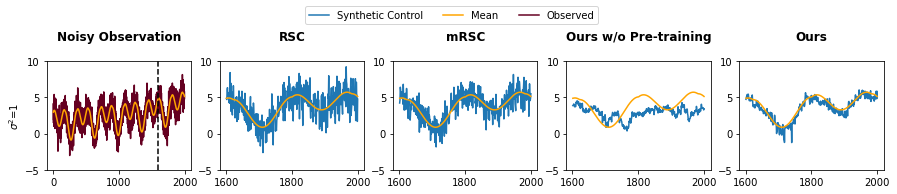

In [9]:
#Plot noise
fig, big_axes = plt.subplots(figsize=(15,2) , nrows=1, ncols=5, sharey=True) 
x = np.arange(interv_time,2000)+1
x_full =  np.arange(2000)+1
for title, big_ax in zip(['Noisy Observation','RSC', 'mRSC','Ours w/o Pre-training','Ours'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')

noise_array = [0.5,1,2]
custom_ylim = [[-3,8],[-5,10],[-15,20]]

a1 = fig.add_subplot(1,5,1)
plt.setp(a1,ylim=custom_ylim[1])
l1=a1.plot(x_full,obs_matrix[1],'xkcd:maroon',label='Observed')
l2=a1.plot(x_full,mean_array_full[1],'orange',label='Mean')
plt.axvline(x =1600,ymin=0, ymax =1 ,linestyle='--',color='black')
plt.ylabel(f'$\sigma^2$={noise_array[1]}')
#a.legend(loc='lower right')
a = fig.add_subplot(1,5,5)
plt.setp(a,ylim=custom_ylim[1])
l3=a.plot(x,dsc_array[1])
l4=a.plot(x,mean_array[1],'orange',label='Mean')

a = fig.add_subplot(1,5,4)
plt.setp(a,ylim=custom_ylim[1])
l3=a.plot(x,dsc_no_pretrain[1])
l4=a.plot(x,mean_array[1],'orange',label='Mean')
#a.legend(loc='lower right')
a = fig.add_subplot(1,5,2)
plt.setp(a,ylim=custom_ylim[1])
l5=a.plot(x,rsc_array[1])
l6=a.plot(x,mean_array[1],'orange',label='Mean')
#a.legend(loc='lower right')
a = fig.add_subplot(1,5,3)
plt.setp(a,ylim=custom_ylim[1])
l7=a.plot(x,mrsc_array[1],label='Synthetic Control')
l8=a.plot(x,mean_array[1],'orange',label='Mean')
#a.legend(loc='lower right')


handles1, labels1 = a.get_legend_handles_labels()
handles2, labels2 = a1.get_legend_handles_labels()
handles1.append(handles2[0])
labels1.append(labels2[0])
fig.legend(handles1,labels1, loc='lower center',ncol=3,bbox_to_anchor=(0.5,1.1))
plt.savefig(f'./figs/noise_one.pdf',bbox_inches='tight')

plt.show()

In [ ]:
#N_donor experiments on finetuning only
N_array = [26,51,76,101]

for N in N_array:

    datapath = f'../datasets/synthetic_data_N_{N}/'
    config_path = f'../exp_configs/synthetic_N_{N}/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_N_{N}/'
    model_path = f'../logs_dir/synthetic_N_{N}/finetune_only/model.pth'
        
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = False
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = False,
                        classes=None,
                       topk=None,
                       weights=None)
    
    
    dscmodel.fit(interv_time,pretrain=True)
    




Pretraining model on donor units
Iteration:0	Loss_mean:0.3904615640640259	Loss_std:0.0
Iteration:100	Loss_mean:0.6209416807070375	Loss_std:0.5625892295888573
Iteration:200	Loss_mean:0.6595190082117915	Loss_std:0.5170242308479472
Iteration:300	Loss_mean:0.43525624375790356	Loss_std:0.40019008988684834
Iteration:400	Loss_mean:0.42422421649098396	Loss_std:0.3997540976344405
Iteration:500	Loss_mean:0.21708337996853516	Loss_std:0.22062514694162577
Iteration:600	Loss_mean:0.17544126333668827	Loss_std:0.15752679263038294
Iteration:700	Loss_mean:0.1778073278069496	Loss_std:0.150428940334217
Iteration:800	Loss_mean:0.14634186015930026	Loss_std:0.10757251883631122
Iteration:900	Loss_mean:0.1382067673979327	Loss_std:0.11148047711155787
Iteration:1000	Loss_mean:0.09881931635085493	Loss_std:0.09007665906115651
Iteration:1100	Loss_mean:0.09128351320046932	Loss_std:0.07141701281893081
Iteration:1200	Loss_mean:0.06745533532928676	Loss_std:0.06488342833458063
Iteration:1300	Loss_mean:0.0510682942392304

Iteration:10900	Loss_mean:0.00987673619238194	Loss_std:0.0064991763572079175
Iteration:11000	Loss_mean:0.010522846363019199	Loss_std:0.007504489221168469
Iteration:11100	Loss_mean:0.00756659516642685	Loss_std:0.005352799906335102
Iteration:11200	Loss_mean:0.010674354691291228	Loss_std:0.009921649866645245
Iteration:11300	Loss_mean:0.009882986611919477	Loss_std:0.008210073235873513
Iteration:11400	Loss_mean:0.010827370419283397	Loss_std:0.009225967968025484
Iteration:11500	Loss_mean:0.010644428709638306	Loss_std:0.010881114509593037
Iteration:11600	Loss_mean:0.009785229897825048	Loss_std:0.01011994728042578
Iteration:11700	Loss_mean:0.009065209305263125	Loss_std:0.006772399444394129
Iteration:11800	Loss_mean:0.00929156291706022	Loss_std:0.008896056306846624
Iteration:11900	Loss_mean:0.009222858143621124	Loss_std:0.007694856555774377
Iteration:12000	Loss_mean:0.009881182473618537	Loss_std:0.008624658081598667
Iteration:12100	Loss_mean:0.009176195139880293	Loss_std:0.008364348117772055
It

Iteration:21600	Loss_mean:0.006795229996787384	Loss_std:0.004350170218875038
Iteration:21700	Loss_mean:0.007061928639886901	Loss_std:0.004738849864812537
Iteration:21800	Loss_mean:0.007746422193013132	Loss_std:0.0061149313647664875
Iteration:21900	Loss_mean:0.006420750764082186	Loss_std:0.00424562487880665
Iteration:22000	Loss_mean:0.006369091884116642	Loss_std:0.004126025669581217
Iteration:22100	Loss_mean:0.007123125565703959	Loss_std:0.00494355750021547
Iteration:22200	Loss_mean:0.006130257220356725	Loss_std:0.0044943519703750665
Iteration:22300	Loss_mean:0.0075796169842942615	Loss_std:0.006045135368490616
Iteration:22400	Loss_mean:0.006150000221969094	Loss_std:0.0040648109402032446
Iteration:22500	Loss_mean:0.006489834683015942	Loss_std:0.004379074985772671
Iteration:22600	Loss_mean:0.005990729997574817	Loss_std:0.003905353567766806
Iteration:22700	Loss_mean:0.006144963293336332	Loss_std:0.0036174609594304646
Iteration:22800	Loss_mean:0.006336962072236929	Loss_std:0.004247015274401

Iteration:32300	Loss_mean:0.0065483649802627044	Loss_std:0.005522276969796783
Iteration:32400	Loss_mean:0.006571520495926961	Loss_std:0.004814310486836975
Iteration:32500	Loss_mean:0.0065337943958002145	Loss_std:0.004797981214572172
Iteration:32600	Loss_mean:0.006457278042507824	Loss_std:0.0040978879017253425
Iteration:32700	Loss_mean:0.005640075861010701	Loss_std:0.003754956873967892
Iteration:32800	Loss_mean:0.006498597044264897	Loss_std:0.004418901480570022
Iteration:32900	Loss_mean:0.007109929599973839	Loss_std:0.004338396807438842
Iteration:33000	Loss_mean:0.00682261164765805	Loss_std:0.00501380087735122
Iteration:33100	Loss_mean:0.005322082040365785	Loss_std:0.0032389178260025524
Iteration:33200	Loss_mean:0.0063974838855210695	Loss_std:0.004788276157975719
Iteration:33300	Loss_mean:0.005930214949185029	Loss_std:0.004093490706802868
Iteration:33400	Loss_mean:0.006068574778037145	Loss_std:0.003843647418813775
Iteration:33500	Loss_mean:0.007083247799891978	Loss_std:0.005398302184386

Iteration:43000	Loss_mean:0.005699262714479118	Loss_std:0.0038905899434280564
Iteration:43100	Loss_mean:0.005881241091119591	Loss_std:0.003786362451730276
Iteration:43200	Loss_mean:0.005980878135596867	Loss_std:0.004192348217720177
Iteration:43300	Loss_mean:0.006496716627152637	Loss_std:0.004135939790169982
Iteration:43400	Loss_mean:0.006154366119299084	Loss_std:0.0035568144273979965
Iteration:43500	Loss_mean:0.00648245035787113	Loss_std:0.004350315129787648
Iteration:43600	Loss_mean:0.005660600078408606	Loss_std:0.003597978434208099
Iteration:43700	Loss_mean:0.005498400505748577	Loss_std:0.0036953947596989416
Iteration:43800	Loss_mean:0.006358239706896711	Loss_std:0.0047329773808623
Iteration:43900	Loss_mean:0.0057618566982273476	Loss_std:0.0037441683770132257
Iteration:44000	Loss_mean:0.006651272278977558	Loss_std:0.004224530798568026
Iteration:44100	Loss_mean:0.005716137215495109	Loss_std:0.003947393026552225
Iteration:44200	Loss_mean:0.0065701359236845745	Loss_std:0.004734263978372

Iteration:3700	Loss_mean:0.005358890483912546	Loss_std:0.0037964312163870475
Iteration:3800	Loss_mean:0.0047616526699857786	Loss_std:0.0029382018758662286
Iteration:3900	Loss_mean:0.005496219306951389	Loss_std:0.0030583351968543997
Iteration:4000	Loss_mean:0.004876441622618586	Loss_std:0.0033276030002391856
Iteration:4100	Loss_mean:0.004902775922964793	Loss_std:0.0030780579786015023
Iteration:4200	Loss_mean:0.005673351666191592	Loss_std:0.0037407872714588083
Iteration:4300	Loss_mean:0.004689334613503888	Loss_std:0.0031721033860199624
Iteration:4400	Loss_mean:0.004268002980388701	Loss_std:0.002614074240612014
Iteration:4500	Loss_mean:0.004593799949798267	Loss_std:0.003270067882222083
Iteration:4600	Loss_mean:0.008339341866085306	Loss_std:0.022064272544058416
Iteration:4700	Loss_mean:0.00466963266080711	Loss_std:0.002796910032086463
Iteration:4800	Loss_mean:0.004501089464174584	Loss_std:0.002835775669524341
Iteration:4900	Loss_mean:0.004917395593074616	Loss_std:0.00330015739386256
Pretra

Iteration:9600	Loss_mean:0.01068164490396157	Loss_std:0.008701188156751123
Iteration:9700	Loss_mean:0.009856455110711976	Loss_std:0.008138674525493614
Iteration:9800	Loss_mean:0.010008563998853788	Loss_std:0.007854189536746572
Iteration:9900	Loss_mean:0.011004570857621729	Loss_std:0.010256963041705926
Iteration:10000	Loss_mean:0.010623845201916993	Loss_std:0.007836407935248086
Iteration:10100	Loss_mean:0.01060999166482361	Loss_std:0.008633772555160306
Iteration:10200	Loss_mean:0.011285782484919763	Loss_std:0.00902648614980223
Iteration:10300	Loss_mean:0.011716754215303809	Loss_std:0.010595890779808709
Iteration:10400	Loss_mean:0.012906943673151546	Loss_std:0.01133131961336097
Iteration:10500	Loss_mean:0.010950877337018028	Loss_std:0.00966398861224841
Iteration:10600	Loss_mean:0.010913554355502128	Loss_std:0.009823935659837565
Iteration:10700	Loss_mean:0.009689508684969041	Loss_std:0.008542695712472464
Iteration:10800	Loss_mean:0.010256794758024625	Loss_std:0.0073908189840248785
Iterati

Iteration:20300	Loss_mean:0.007981679012300447	Loss_std:0.0055357606516263655
Iteration:20400	Loss_mean:0.008355271944310516	Loss_std:0.005432210186780365
Iteration:20500	Loss_mean:0.007072763891192153	Loss_std:0.005326196295846835
Iteration:20600	Loss_mean:0.00864845271105878	Loss_std:0.005585339168384611
Iteration:20700	Loss_mean:0.007741300548077561	Loss_std:0.00480806810194332
Iteration:20800	Loss_mean:0.007668245415552519	Loss_std:0.005247137921654762
Iteration:20900	Loss_mean:0.007990960768656805	Loss_std:0.005276906300419985
Iteration:21000	Loss_mean:0.00794329776923405	Loss_std:0.0050231317531297505
Iteration:21100	Loss_mean:0.007218185234232805	Loss_std:0.004664213945590448
Iteration:21200	Loss_mean:0.008419588099932297	Loss_std:0.005313256182884204
Iteration:21300	Loss_mean:0.007989444488775916	Loss_std:0.006262263048896185
Iteration:21400	Loss_mean:0.00760537037946051	Loss_std:0.005760956931164117
Iteration:21500	Loss_mean:0.0074086874723434445	Loss_std:0.005656163605616744


Iteration:31000	Loss_mean:0.00621422728523612	Loss_std:0.00387078444739352
Iteration:31100	Loss_mean:0.006669799288501963	Loss_std:0.004249436129123398
Iteration:31200	Loss_mean:0.007350051066605374	Loss_std:0.004712616436633884
Iteration:31300	Loss_mean:0.0066154324344824995	Loss_std:0.0038265504720898535
Iteration:31400	Loss_mean:0.006775035587488674	Loss_std:0.004010455206343957
Iteration:31500	Loss_mean:0.006446327012090478	Loss_std:0.004285807455862094
Iteration:31600	Loss_mean:0.006719470943789929	Loss_std:0.004635655079822901
Iteration:31700	Loss_mean:0.00722465171595104	Loss_std:0.004684103214930032
Iteration:31800	Loss_mean:0.0064954755658982325	Loss_std:0.005483382426922788
Iteration:31900	Loss_mean:0.0064638342068064954	Loss_std:0.004469524585242595
Iteration:32000	Loss_mean:0.006713296887173783	Loss_std:0.004989788723879418
Iteration:32100	Loss_mean:0.0063523146323859695	Loss_std:0.004528777656481084
Iteration:32200	Loss_mean:0.007315261614276096	Loss_std:0.0047553389141010

Iteration:41700	Loss_mean:0.006462222734699026	Loss_std:0.0037141691611760528
Iteration:41800	Loss_mean:0.006318037412711419	Loss_std:0.0037193632772311866
Iteration:41900	Loss_mean:0.006317184147774242	Loss_std:0.004998194756241101
Iteration:42000	Loss_mean:0.006905843060812913	Loss_std:0.00432332890252942
Iteration:42100	Loss_mean:0.007002575483929832	Loss_std:0.0046513066438904635
Iteration:42200	Loss_mean:0.006281780147110112	Loss_std:0.004191090060316998
Iteration:42300	Loss_mean:0.005802260019700043	Loss_std:0.004186585871113451
Iteration:42400	Loss_mean:0.00626551806810312	Loss_std:0.004238452783233233
Iteration:42500	Loss_mean:0.005812746239244006	Loss_std:0.004161717674029561
Iteration:42600	Loss_mean:0.006858930861344561	Loss_std:0.004111013901628572
Iteration:42700	Loss_mean:0.005928009808121715	Loss_std:0.00380292155989984
Iteration:42800	Loss_mean:0.006670209566364065	Loss_std:0.00499528681865349
Iteration:42900	Loss_mean:0.007164758188882843	Loss_std:0.005344866813893499


Iteration:2400	Loss_mean:0.0058195364015409725	Loss_std:0.003506721983459851
Iteration:2500	Loss_mean:0.0054061197105329485	Loss_std:0.0035776737326281057
Iteration:2600	Loss_mean:0.005462311912269797	Loss_std:0.009436847405709207
Iteration:2700	Loss_mean:0.005504058216465637	Loss_std:0.0035691006339293244
Iteration:2800	Loss_mean:0.0057166670967126266	Loss_std:0.0038405109475852374
Iteration:2900	Loss_mean:0.005287257794116158	Loss_std:0.0034465495061474297
Iteration:3000	Loss_mean:0.005441130321705714	Loss_std:0.004200723887983792
Iteration:3100	Loss_mean:0.0055107254179893065	Loss_std:0.003624055687593409
Iteration:3200	Loss_mean:0.005367062535369769	Loss_std:0.0037281632162311936
Iteration:3300	Loss_mean:0.006748543595895171	Loss_std:0.01689867493811029
Iteration:3400	Loss_mean:0.005752761151525192	Loss_std:0.004083303032414415
Iteration:3500	Loss_mean:0.0047799655146081935	Loss_std:0.003396288740366362
Iteration:3600	Loss_mean:0.005035736093122978	Loss_std:0.0030795616847729182
It

In [2]:
#Extract results
N_array = [6,11,16,26,51,76,101]
# N_array = [11]
rsc_array = []
mrsc_array = []
dsc_array = []
dsc_no_pretrain = []
mean_array = []
obs_matrix = []
mean_array_full = []
mc_nnm = []
synctwin = []

for N in N_array:
    for id in range(1):
        
        if N==11:
            datapath = f'../datasets/synthetic_data_noise_{id+1}/'
            config_path = '../exp_configs/synthetic_noise/config.yaml'
            config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
            op_path = '../logs_dir/synthetic/'
            if not(os.path.exists(op_path)):
                os.mkdir(op_path)
            random_seed = 0
            target_index = 0
            interv_time = 1500
            lowrank = False
            model_path = '../logs_dir/synthetic_noise_1/finetune/model.pth'
            model_path_finetune_only = '../logs_dir/synthetic_noise_1/finetune_only/model.pth'
        else:
            datapath = f'../datasets/synthetic_data_N_{N}_{id+1}/'
            config_path = f'../exp_configs/synthetic_N_{N}/config.yaml'
            config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
            op_path = f'../logs_dir/synthetic_N_{N}/'
            model_path = f'../logs_dir/synthetic_N_{N}/finetune/model.pth'
            model_path_finetune_only = f'../logs_dir/synthetic_N_{N}/finetune_only/model.pth'

        random_seed = 0
        target_index = 0
        interv_time = 1500
        lowrank = False
        
        device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
        classes = None
        config_model = BertConfig(hidden_size = config['hidden_size'],
                                num_hidden_layers = config['n_layers'],
                                num_attention_heads = config['n_heads'],
                                intermediate_size = 4*config['hidden_size'],
                                vocab_size = 0,
                                max_position_embeddings = 0,
                                output_hidden_states = True,
                                )

        config_model.add_syn_ctrl_config(K=config['K'],
                                        pre_int_len=config['pre_int_len'],
                                        post_int_len=config['post_int_len'],
                                        feature_dim=config['feature_dim'],
                                        time_range=config['time_range'],
                                        seq_range=config['seq_range'],
                                        cont_dim=config['cont_dim'],
                                        discrete_dim=config['discrete_dim'],
                                        classes = classes)
        model = Bert2BertSynCtrl(config_model, random_seed)
        model = model.to(device)
        dscmodel = DSCModel(model,
                            config,
                            op_path,
                            target_index,
                            random_seed,
                            datapath,
                            device,
                            lowrank = False,
                            classes=None,
                           topk=None,
                           weights=None)


        dscmodel.load_model_from_checkpoint(model_path)
        op = dscmodel.predict(interv_time)
        obs = np.load(datapath+'obs1.npy')
        obs_matrix.append(obs[0])


        dscmodel.load_model_from_checkpoint(model_path_finetune_only)
        op_2 = dscmodel.predict(interv_time)

        #MSE
        meanmatrix = np.load(datapath+'mean1.npy')
        test_mean = meanmatrix[0,interv_time:]
        pred_mean=op[interv_time:]
        pred_mean2 = op_2[interv_time:]
        print(N,id)
        print('With pretraining:',np.sqrt(np.mean((pred_mean - test_mean)**2)))
        print('Without pretraining:',np.sqrt(np.mean((pred_mean2 - test_mean)**2)))
        mean_array_full.append(meanmatrix[0])
        mean_array.append(test_mean)
        dsc_array.append(pred_mean)
        dsc_no_pretrain.append(pred_mean2)
        rsc_array.append(np.load(datapath+'rsc_pred.npy'))
        mrsc_array.append(np.load(datapath+'mrsc_pred.npy'))
        if N==11:
            mc_nnm.append(pd.read_csv('../datasets/synthetic_noise1_1/'+'mc_nnm_pred.csv', sep=',',header=None))
            synctwin.append(np.load('../datasets/synthetic_noise1_1/'+'pred_synctwin.npy'))
        else:
            mc_nnm.append(pd.read_csv(datapath+'mc_nnm_pred.csv', sep=',',header=None))
            synctwin.append(np.load(datapath+'pred_synctwin.npy'))
        


Modifying K
6 0
With pretraining: 0.5562255
Without pretraining: 1.808221
Modifying K
11 0
With pretraining: 0.5583670132851428
Without pretraining: 1.5139592474528405
Modifying K
16 0
With pretraining: 0.5719295
Without pretraining: 1.6006727
Modifying K
26 0
With pretraining: 0.46687928
Without pretraining: 1.2387917
Modifying K
51 0
With pretraining: 0.3330091
Without pretraining: 1.5310389
Modifying K
76 0
With pretraining: 0.40082225
Without pretraining: 1.294872
Modifying K
101 0
With pretraining: 0.47809565
Without pretraining: 1.707472


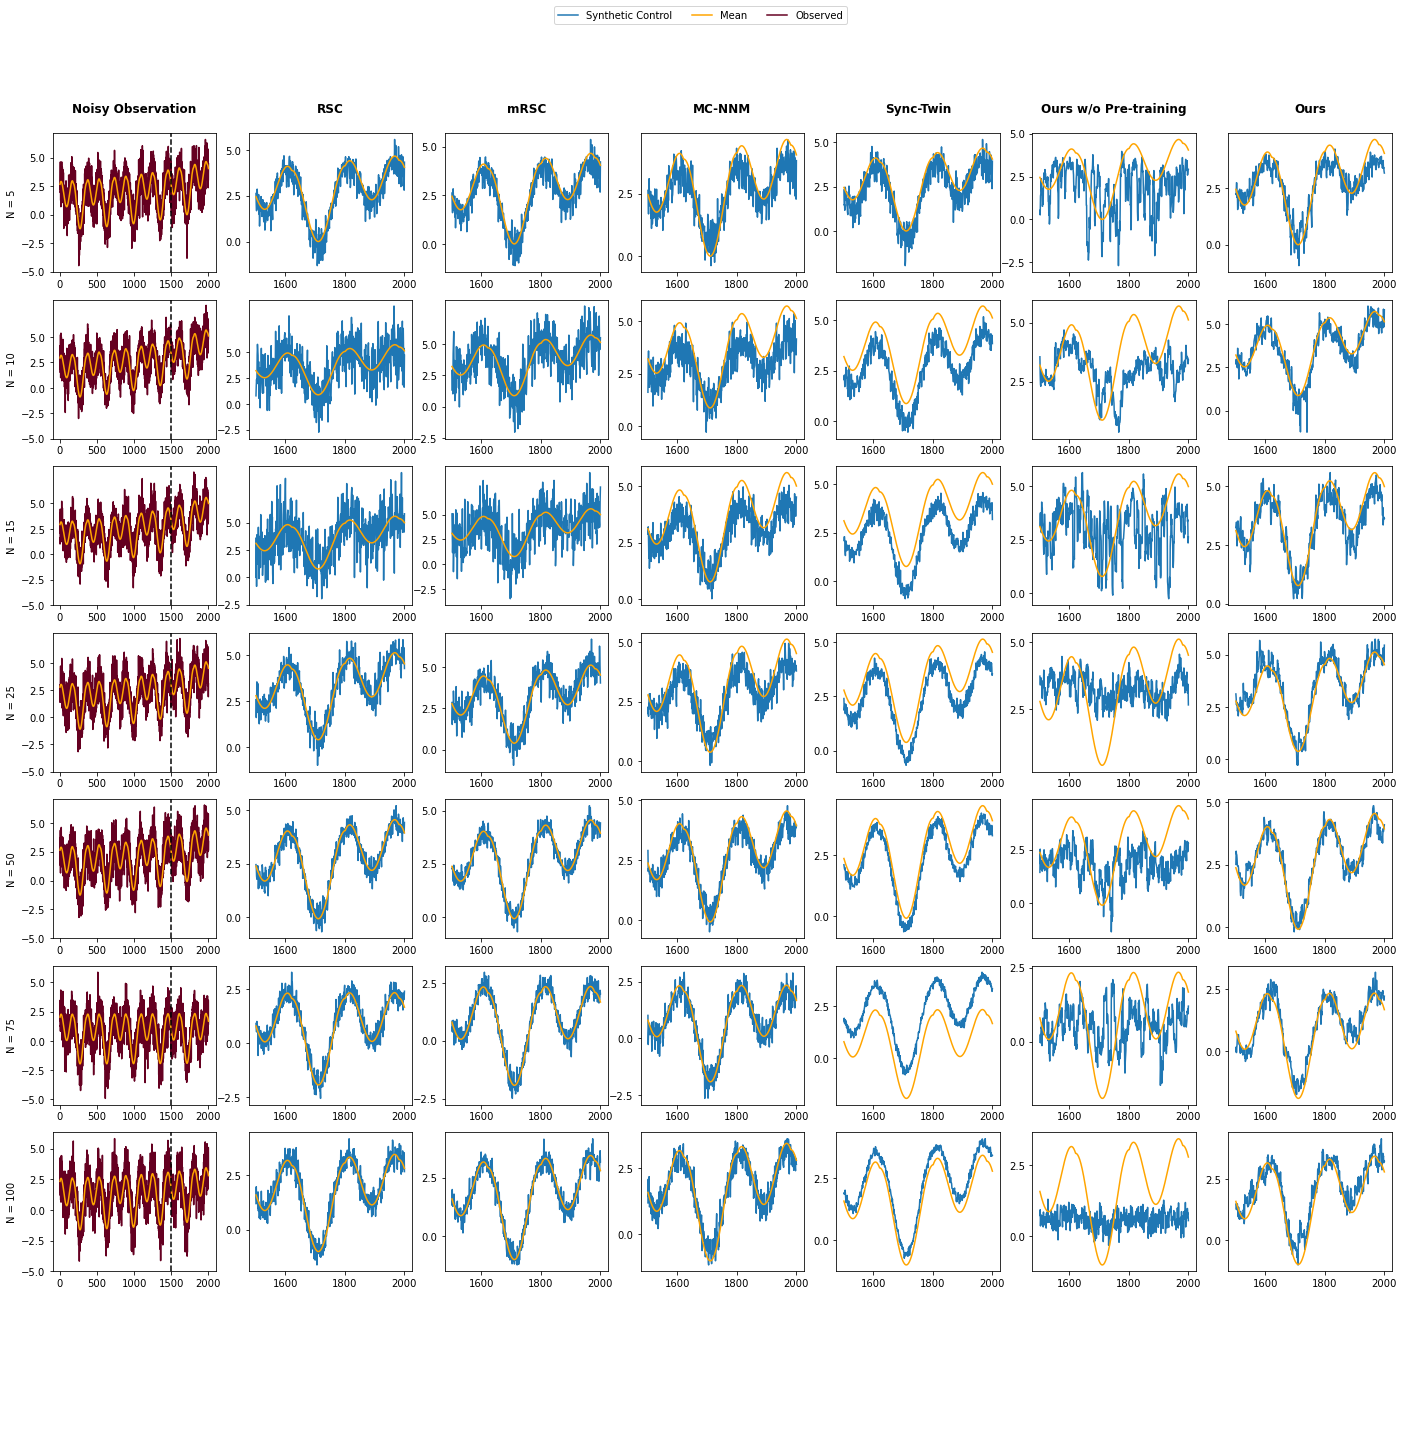

In [3]:
#Plots
fig, big_axes = plt.subplots(figsize=(24, 24) , nrows=1, ncols=7, sharey=True) 
x = np.arange(interv_time,2000)+1
x_full =  np.arange(2000)+1
for title, big_ax in zip(['Noisy Observation','RSC', 'mRSC','MC-NNM','Sync-Twin','Ours w/o Pre-training','Ours'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')

#custom_ylim = [[-3,8],[-2,8],[-15,20]]
N_array = [5,10,15,25,50,75,100]
yticks = np.arange(-5,6,step=2.5)
for i in range(1,50,7):
        a1 = fig.add_subplot(8,7,i)
        #plt.setp(a1,ylim=custom_ylim[int(i/4)])
        l1=a1.plot(x_full,obs_matrix[int(i/7)],'xkcd:maroon',label='Observed')
        l2=a1.plot(x_full,mean_array_full[int(i/7)],'orange',label='Mean')
        a1.set_yticks(yticks)
        plt.axvline(x =1500,ymin=0, ymax =1 ,linestyle='--',color='black')
        plt.ylabel(f'N = {N_array[int(i/7)]}')
        #a.legend(loc='lower right')
        a = fig.add_subplot(8,7,i+6)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        a.set_yticks(yticks)
        l3=a.plot(x,dsc_array[int(i/7)])
        l4=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
        a = fig.add_subplot(8,7,i+5)
        a.set_yticks(yticks)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l3=a.plot(x,dsc_no_pretrain[int(i/7)])
        l4=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(8,7,i+1)
        a.set_yticks(yticks)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l5=a.plot(x,rsc_array[int(i/7)])
        l6=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(8,7,i+2)
        a.set_yticks(yticks)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l7=a.plot(x,mrsc_array[int(i/7)],label='Synthetic Control')
        l8=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(8,7,i+3)
        a.set_yticks(yticks)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l7=a.plot(x,mc_nnm[int(i/7)].to_numpy()[1:,].reshape(-1).astype('float32'),label='Synthetic Control')
        l8=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(8,7,i+4)
        a.set_yticks(yticks)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l7=a.plot(x,synctwin[int(i/7)][:,0],label='Synthetic Control')
        l8=a.plot(x,mean_array[int(i/7)],'orange',label='Mean')
        #a.legend(loc='lower right')


handles1, labels1 = a.get_legend_handles_labels()
handles2, labels2 = a1.get_legend_handles_labels()
handles1.append(handles2[0])
labels1.append(labels2[0])
fig.legend(handles1,labels1, loc='lower center',ncol=3,bbox_to_anchor=(0.5,0.94))
plt.savefig(f'./figs/donorpool_all.pdf',bbox_inches='tight')

plt.show()

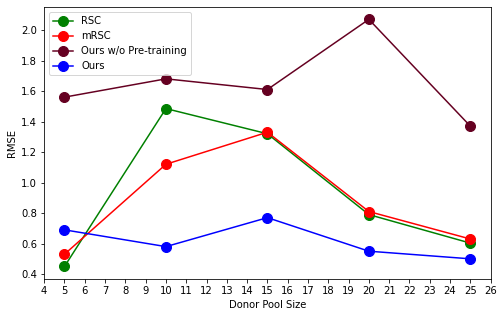

In [3]:
dsc= [0.69,0.58,0.77,0.55,0.5]
dsc_no_pretrain = [1.56,1.68,1.61,2.07,1.37]
msc = [0.53,1.12,1.33,0.81,0.63]
rsc = [0.45,1.485, 1.32 ,0.79, 0.603]
N = [5,10,15,20,25]
yint = range(3,28)
plt.figure(figsize=(8, 5))
plt.xticks(yint)

plt.plot(N,rsc,'og-',label='RSC',markersize=10)
plt.plot(N,msc,'or-',label='mRSC',markersize=10)
plt.plot(N,dsc_no_pretrain,color='xkcd:maroon',marker='o',label='Ours w/o Pre-training',markersize=10)
plt.plot(N,dsc,'ob-',label='Ours',markersize=10)
plt.xlabel('Donor Pool Size')
plt.ylabel('RMSE')
plt.legend()
plt.savefig(f'./figs/donorpool.pdf',bbox_inches='tight')

In [8]:
missing_array = [0.1,0.2,0.3,0.5]
rsc_array = []
mrsc_array = []
dsc_array = []
dsc_no_pretrain = []
mean_array = []
obs_matrix = []
mean_array_full = []
obs_x = []

for p in missing_array:
    
    datapath = f'../datasets/synthetic_data_missing_{p}/'
    config_path = f'../exp_configs/synthetic_noise/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_missing_{p}/'
    model_path = f'../logs_dir/synthetic_missing_{p}/finetune/model.pth'
    #model_path_finetune_only =  f'../logs_dir/synthetic_missing_{p}/finetune_only/model.pth'
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = True
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = True,
                        classes=None)
    interv_time = 1600
    dscmodel.load_model_from_checkpoint(model_path)
    op = dscmodel.predict(interv_time)
    mask = np.load(datapath+'mask.npy')
    mask_target = mask[0,:,0]
    obs = np.load(datapath+'data.npy')[:,:,0]
    obs_matrix.append(obs[0][mask_target==0])
    print()
    x_full =  np.arange(2000)+1
    obs_x.append(x_full[mask_target==0])
    #dscmodel.load_model_from_checkpoint(model_path_finetune_only)
    #op_2 = dscmodel.predict(interv_time)
    
    #MSE
    meanmatrix = np.load(datapath+'mean1.npy')
    test_mean = meanmatrix[0,interv_time:]
    pred_mean=op[interv_time:]
    #pred_mean2 = op_2[interv_time:]
    print('With pretraining:',np.sqrt(np.mean((pred_mean - test_mean)**2)))
    #print('Without pretraining:',np.sqrt(np.mean((pred_mean2 - test_mean)**2)))
    mean_array_full.append(meanmatrix[0])
    mean_array.append(test_mean)
    dsc_array.append(pred_mean)
    #dsc_no_pretrain.append(pred_mean2)
    rsc_array.append(np.load(datapath+'rsc_pred.npy'))
    mrsc_array.append(np.load(datapath+'mrsc_pred.npy'))

Modifying K
Low rank conversion done

With pretraining: 1.7451126789476632
Modifying K
Low rank conversion done

With pretraining: 1.7911034219076487
Modifying K
Low rank conversion done

With pretraining: 2.0617820366005875
Modifying K
Low rank conversion done

With pretraining: 2.5373473827418604


In [7]:
missing_array = [0.1,0.2,0.3,0.5]
rsc_array = []
mrsc_array = []
dsc_array = []
dsc_no_pretrain = []
mean_array = []
obs_matrix = []
mean_array_full = []
obs_x = []

for p in missing_array:
    
    datapath = f'../datasets/synthetic_data_missing_{p}/'
    config_path = f'../exp_configs/synthetic_noise/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_missing_{p}_no_denoising/'
    model_path =  f'../logs_dir/synthetic_missing_{p}_no_denoising/finetune/model.pth'
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = True
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank =False,
                        classes=None)
    interv_time = 1500
    dscmodel.load_model_from_checkpoint(model_path)
    op = dscmodel.predict(interv_time)
    #MSE
    meanmatrix = np.load(datapath+'mean1.npy')
    test_mean = meanmatrix[0,interv_time:]
    pred_mean=op[interv_time:]
    print('Without denoising:',np.sqrt(np.mean((pred_mean - test_mean)**2)))


Modifying K
Without denoising: 1.1649465700585984
Modifying K
Without denoising: 1.3608462110252122
Modifying K
Without denoising: 1.4513699959713768
Modifying K
Without denoising: 3.174849269082771


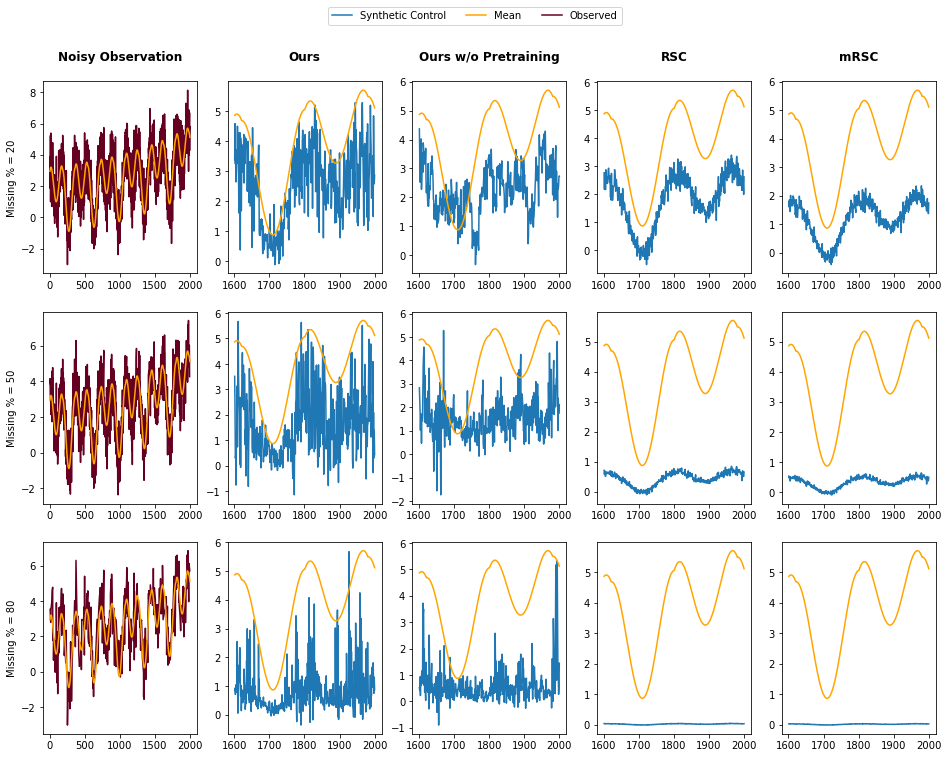

In [18]:
#Plots
fig, big_axes = plt.subplots(figsize=(16, 12) , nrows=1, ncols=5, sharey=True) 
x = np.arange(interv_time,2000)+1
x_full =  np.arange(2000)+1
for title, big_ax in zip(['Noisy Observation','Ours','Ours w/o Pretraining','RSC', 'mRSC'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')

p_array = [0.2,0.5,0.8]
for i in range(1,16,5):
        a1 = fig.add_subplot(3,5,i)
        #plt.setp(a1,ylim=custom_ylim[int(i/4)])
        l1=a1.plot(obs_x[int(i/5)],obs_matrix[int(i/5)],'xkcd:maroon',label='Observed')
        l2=a1.plot(x_full,mean_array_full[int(i/5)],'orange',label='Mean')
        plt.ylabel(f'Missing % = {int(p_array[int(i/5)]*100)}')
        #a.legend(loc='lower right')
        a = fig.add_subplot(3,5,i+1)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l3=a.plot(x,dsc_array[int(i/5)])
        l4=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        a = fig.add_subplot(3,5,i+2)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l3=a.plot(x,dsc_no_pretrain[int(i/5)])
        l4=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(3,5,i+3)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l5=a.plot(x,rsc_array[int(i/5)])
        l6=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(3,5,i+4)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l7=a.plot(x,mrsc_array[int(i/5)],label='Synthetic Control')
        l8=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        #a.legend(loc='lower right')


handles1, labels1 = a.get_legend_handles_labels()
handles2, labels2 = a1.get_legend_handles_labels()
handles1.append(handles2[0])
labels1.append(labels2[0])
fig.legend(handles1,labels1, loc='lower center',ncol=3,bbox_to_anchor=(0.5,0.94))
plt.savefig(f'./figs/missing.pdf',bbox_inches='tight')

plt.show()